<a href="https://colab.research.google.com/github/Firizki17/Pengolahan-Citra-Digital/blob/main/Frequency_Domain_Filter_Gaussian_Filter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Muh Firizki (Universitas MDP)

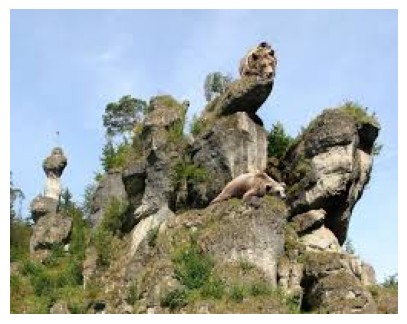

In [13]:
# libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt
import requests

# Download the image using requests
image_url = 'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQy7tILm84mxQLPOz_O4LiJxcYUTh-_-xW_aQ&s.png'
response = requests.get(image_url, stream=True)
response.raise_for_status()  # Raise an exception for bad responses (4xx or 5xx)

# Read the image data from the response content using OpenCV
image_array = np.asarray(bytearray(response.content), dtype="uint8")
# Decode the image data without converting to grayscale
F = cv2.imdecode(image_array, cv2.IMREAD_COLOR) # Decode the image data

# Convert BGR (default OpenCV color format) to RGB for matplotlib display
F = cv2.cvtColor(f, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(5,5))
plt.imshow(f)
plt.axis('off')
plt.show()

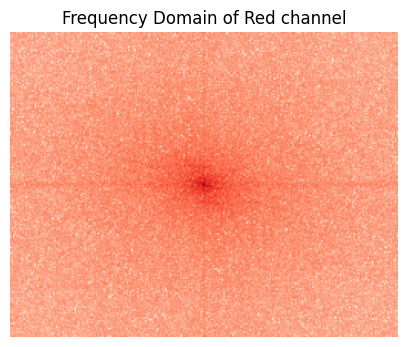

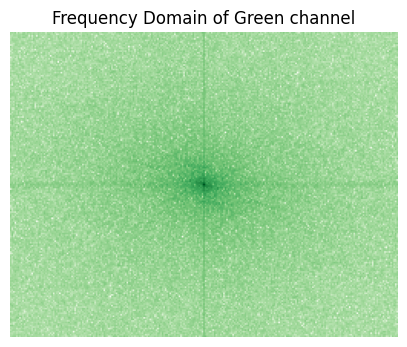

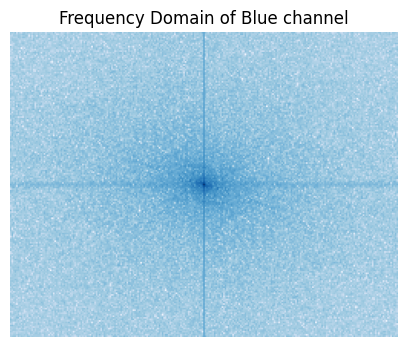

In [14]:
# Function to apply FFT and plot for each channel with colormap
def plot_fft_colored(image, channel_name, cmap):
    # Apply FFT on the single channel image
    F = np.fft.fft2(image)
    Fshift = np.fft.fftshift(F)

    # Plot the FFT result using colormap
    plt.figure(figsize=(5,5))
    plt.title(f'Frequency Domain of {channel_name} channel')
    plt.imshow(np.log1p(np.abs(Fshift)), cmap=cmap)
    plt.axis('off')
    plt.show()

# Apply FFT and display results for each channel using different colormaps
plot_fft_colored(R, "Red", 'Reds')
plot_fft_colored(G, "Green", 'Greens')
plot_fft_colored(B, "Blue", 'Blues')


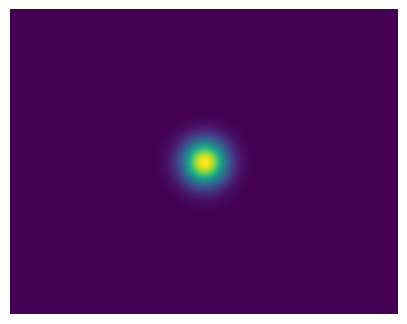

In [15]:
# Create Gaussian Filter: Low Pass Filter (still in grayscale, but we apply a color map for display)
M, N = f.shape[:2]  # Only use the first two dimensions of the image (height and width)
H = np.zeros((M, N), dtype=np.float32)
D0 = 10  # Cutoff frequency

for u in range(M):
    for v in range(N):
        D = np.sqrt((u - M / 2) ** 2 + (v - N / 2) ** 2)
        H[u, v] = np.exp(-D**2 / (2 * D0 * D0))

# Display the filter using a colormap (e.g., 'viridis' for a color representation)
plt.figure(figsize=(5,5))
plt.imshow(H, cmap='viridis')  # Using viridis color map for visualization
plt.axis('off')
plt.show()


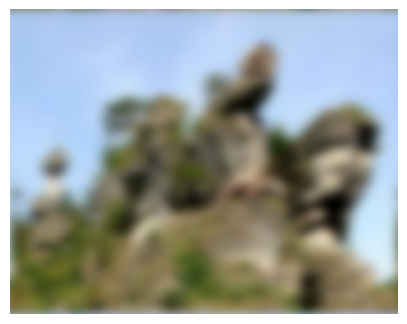

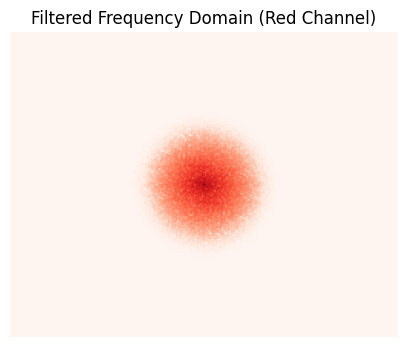

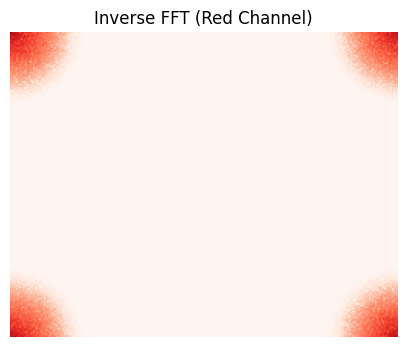

In [16]:
# Apply filter in the frequency domain for each channel
def apply_filter(image_channel, H):
    # Apply FFT
    F = np.fft.fft2(image_channel)
    Fshift = np.fft.fftshift(F)

    # Apply the Gaussian filter in the frequency domain
    Gshift = Fshift * H

    # Inverse FFT to transform back to spatial domain
    G = np.fft.ifftshift(Gshift)
    g = np.abs(np.fft.ifft2(G))

    return g, Gshift, G

# Apply filter to each color channel (R, G, B)
R_filtered, R_Gshift, R_G = apply_filter(R, H)
G_filtered, G_Gshift, G_G = apply_filter(G, H)
B_filtered, B_Gshift, B_G = apply_filter(B, H)

# Combine the filtered channels back into an RGB image
RGB_filtered = cv2.merge([R_filtered, G_filtered, B_filtered])

# Normalize the filtered image for display
RGB_filtered = cv2.normalize(RGB_filtered, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')

# Display the filtered image in color
plt.figure(figsize=(5,5))
plt.imshow(RGB_filtered)
plt.axis('off')
plt.show()

# Optionally, display the frequency domain results (Gshift) for one channel, e.g., Red
plt.figure(figsize=(5,5))
plt.title('Filtered Frequency Domain (Red Channel)')
plt.imshow(np.log1p(np.abs(R_Gshift)), cmap='Reds')
plt.axis('off')
plt.show()

# You can also display the inverse FFT results (spatial domain) for the Red channel
plt.figure(figsize=(5,5))
plt.title('Inverse FFT (Red Channel)')
plt.imshow(np.log1p(np.abs(R_G)), cmap='Reds')
plt.axis('off')
plt.show()


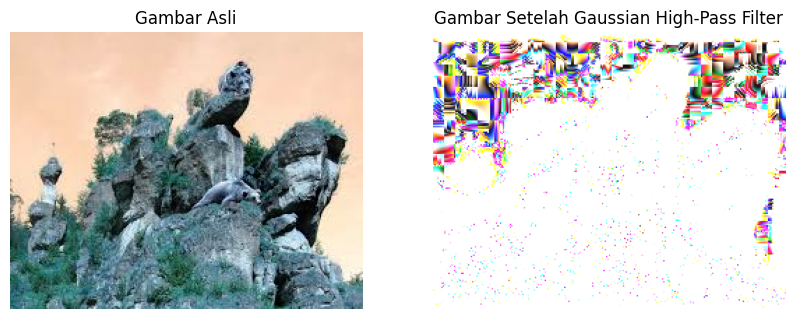

In [20]:
# Pisahkan gambar menjadi saluran R, G, B
R, G, B = cv2.split(F) # Change 'image' to 'F'

# Fungsi untuk menerapkan FFT dan High-Pass Filter pada satu saluran
def process_channel_high_pass(channel, D0):
    # Terapkan FFT
    F = np.fft.fft2(channel)
    Fshift = np.fft.fftshift(F)

    # Buat filter Gaussian Low-Pass
    M, N = channel.shape
    H = np.zeros((M, N), dtype=np.float32)
    for u in range(M):
        for v in range(N):
            D = np.sqrt((u - M/2)**2 + (v - N/2)**2)
            H[u, v] = np.exp(-D**2 / (2 * D0 * D0))

    # Buat High-Pass Filter
    HPF = 1 - H

    # Terapkan filter pada domain frekuensi
    Gshift = Fshift * HPF
    G = np.fft.ifftshift(Gshift)

    # Kembali ke domain spasial
    g = np.abs(np.fft.ifft2(G))
    return g

# Tentukan cutoff frequency untuk High-Pass Filter
D0 = 10

# Proses setiap saluran dengan High-Pass Filter
R_processed = process_channel_high_pass(R, D0)
G_processed = process_channel_high_pass(G, D0)
B_processed = process_channel_high_pass(B, D0)

# Gabungkan kembali saluran R, G, B
processed_image = cv2.merge([R_processed, G_processed, B_processed])

# Tampilkan gambar asli dan hasil setelah High-Pass Filter
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(F) # Change 'image' to 'F'
plt.title('Gambar Asli')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(processed_image)
plt.title('Gambar Setelah Gaussian High-Pass Filter')
plt.axis('off')

plt.show()